In [2]:
#import 

import pandas as pd
import folium
import numpy as np
from shapely import LineString
from shapely.geometry import Point
import geopandas as gpd
from folium.plugins import HeatMap, HeatMapWithTime


In [3]:
callsign_fields=['FlightId','acmodel']
track_fields = ['time','lon','lat','FlightId']

callsign_df = pd.read_csv('data/callsigns.csv',skipinitialspace=True, usecols=callsign_fields)
tracks_df = pd.read_csv('data/tracks.csv',skipinitialspace=True, usecols=track_fields)

In [31]:
#getting tug callsigns
mask = callsign_df['acmodel']=='TUG'
callsigns = sorted(set(callsigns[mask]['FlightId']))

In [48]:
#filtering only known tugs from the list
filtered_df = tracks_df[tracks_df['FlightId'].isin(callsigns)]
filtered_df.reset_index(inplace=True,drop=True)

In [230]:
#transforming the filtered_df to a geodataframe and intersecting it with the polygon of our interest

geometries=list()
keys=list()
timestamps = list()
dates = list()

for key , grp in filtered_df.groupby('FlightId'):
    geometry = [Point(xy) for xy in zip(grp['lat'], grp['lon'])]
    geometries.append(LineString(geometry))
    keys.append(key)
    dates.append(int(grp['time'].iloc[0].split(' ')[0][8:10]))
    timestamps.append(grp['time'].iloc[0].split(' ')[1][0:5])

#adding everything to GeoDataFrame
gdf = gpd.GeoDataFrame({'key': keys, 'time':timestamps,'date':dates,'geometry': geometries})
gdf.crs= 4326
gdf.head()

,key,time,date,geometry
0,9928521,03:21,1,"LINESTRING (52.30580 4.77513, 52.30582 4.77516..."
1,9928522,03:22,1,"LINESTRING (52.31454 4.76151, 52.31453 4.76155..."
2,9928529,03:36,1,"LINESTRING (52.29494 4.78239, 52.29496 4.78241..."
3,9928534,03:43,1,"LINESTRING (52.29801 4.78630, 52.29790 4.78623..."
4,9928539,03:46,1,"LINESTRING (52.29709 4.78343, 52.29705 4.78340..."


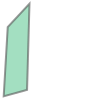

In [325]:
#defining the polygon of interest (this can be changed with a 'per-pier approach')

#todo read .kmz files from GOOGLE EARTH instead of this
df=pd.DataFrame({'latD':[52]*5,
                 'latM':[18,19,18,18,18],
                 'latS':[59,2,35,30,59],
                 'lonD':[4]*5,
                 'lonM':[44,46,45,44,44],
                 'lonS':[33,20,51,25,33],
                })
def dms_to_dec(d, m, s):
    sign = 1 - 2 * np.signbit(d)
    return d + sign * m / 60 + sign * s / 3600
    
points = df.apply(lambda row: (dms_to_dec(*row[['latD', 'latM', 'latS']]), 
                                    dms_to_dec(*row[['lonD', 'lonM', 'lonS']])),
                  axis=1)
# poly_gdf = gpd.GeoDataFrame(df, geometry=points, crs={'init': 'EPSG:4326'})

polygon = Polygon(points)
polygon

In [282]:
import folium

# Create a folium map centered on Schiphol
map_center = [52.308, 4.765]
m = folium.Map(location=map_center, zoom_start=13)

# Define the coordinates of the polygon
polygon_coords = [[52.31638888888889, 4.7425],
                  [52.31722222222223, 4.772222222222222],
                  [52.30972222222222, 4.764166666666667],
                  [52.30833333333333, 4.740277777777778],
                  [52.31638888888889,4.7425]
]

# Create a polygon using the coordinates
polygon = folium.Polygon(locations=points, color='red', fill=True, fill_color='red')

# Add the polygon to the map
polygon.add_to(m)

# Display the map
m


In [284]:
#selecting only the trajectories that intersect the polygon.
mask_list=list()
for i in range(0,len(gdf)):
    mask = gdf.iloc[i]['geometry'].intersects(polygon)
    mask_list.append(mask)

#the gdf that contains only trajectories from that polygon
sub_gdf = gdf[pd.Series(mask_list)]
sub_gdf.head()

,key,time,date,geometry
1,9928522,03:22,1,"LINESTRING (52.31454 4.76151, 52.31453 4.76155..."
8,9928628,04:46,1,"LINESTRING (52.31438 4.75724, 52.31445 4.75906..."
9,9928634,04:46,1,"LINESTRING (52.31407 4.75451, 52.31410 4.75454..."
15,9928854,06:20,1,"LINESTRING (52.31440 4.75637, 52.31441 4.75643..."
22,9931226,13:20,1,"LINESTRING (52.31545 4.76177, 52.31544 4.76173..."


In [324]:
# Create a folium map centered around Amsterdam Schiphol Airport
map_center = [52.308056, 4.764167]  # Latitude, Longitude of Schiphol Airport
map_zoom = 13  # Adjust the zoom level as needed
m = folium.Map(location=map_center, zoom_start=map_zoom)

# Define the coordinates of the polygon of interest
polygon_coords = [[52.31638888888889, 4.7425],
                  [52.31722222222223, 4.772222222222222],
                  [52.30972222222222, 4.764166666666667],
                  [52.30833333333333, 4.740277777777778],
                  [52.31638888888889,4.7425]
]

# Create a polygon using the coordinates
polygon = folium.Polygon(locations=polygon_coords, color='red', fill=True, fill_color='red')

#create a handle for the polygon layer
polygon_filter = folium.FeatureGroup(name='Polygon')
polygon.add_to(polygon_filter)
##add it to the map
polygon_filter.add_to(m)

# Create a group for the trajectories
trajectories_group = folium.FeatureGroup(name='Trajectories')

# Create a group for the first elements of each trajectory
first_elements_group = folium.FeatureGroup(name='First Elements')

# Create a group for the first elements of each trajectory
last_elements_group = folium.FeatureGroup(name='Last Elements')

# Create a group for the first elements of each trajectory
last_elements_heatmap = folium.FeatureGroup(name='Last Elements Heatmap')

heat_data = list()
# Add the trajectory points as blue markers
for index, row in sub_gdf.iterrows():
    
    #we have to plot every point...
    for points in list(row['geometry'].coords):
    
        folium.CircleMarker(
            location=points,
            radius=1,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.4
        ).add_to(trajectories_group)

    folium.CircleMarker(
                location=list(row['geometry'].coords)[0],
                radius=2,
                color='green',
                fill=True,
                fill_color='green',
                fill_opacity=0.4
            ).add_to(first_elements_group)
    
    folium.CircleMarker(
                location=list(row['geometry'].coords)[-1],
                radius=2,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.4
            ).add_to(last_elements_group)
    
    heat_data.append(list(row['geometry'].coords[-1]))

# Add the trajectory and first elements groups to the map
trajectories_group.add_to(m)
first_elements_group.add_to(m)
last_elements_group.add_to(m)

# Add the HeatMap 
HeatMap(heat_data).add_to(last_elements_heatmap)
last_elements_heatmap.add_to(m)

# Create a layer control for toggling the groups
folium.LayerControl().add_to(m)

# Save the map to an HTML file
map_filename = 'trajectory_map.html'
m.save(map_filename)

print(f"Map saved to {map_filename}")

#show the map directly
#m

Map saved to trajectory_map.html
